# Notebook batch-1831-land-cover-mapping

## Imports

In [313]:
from PIL import Image
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import shutil
import os
import rasterio
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

### Approche globale 

- Data preparation
- Construction et entrainement d'un premier modèle (incl. identifier un modèle plus puissant potentiellement)
- Finetuner le modèle
- Appliquer à google map (incl. API)
- Construction de l'interface

## Data preparation

Télécharger l'ensemble des données, les consolder et construire le train, val, test set

**Approche :**
- Télécharger les set de données (OpenG & XBD), consolider l'ensemble
- Identifier le nom des images pour les sets (train/val/test)
- Processer les images (ex: np.transpose)
- Calculer les différentes résolutions disponibles et les cas à appliquer (crop/diviser les images) pour faciliter l'entrainement
- Vérifier si certaines données (esp. labels) sont manquantes
- Construire les dossier train / val + test
- Processer la donnée (ex : /255) 

### Uploader les images manquantes de XBD

In [2]:
########### IL VA FALLOIR UPLOADER LES ELEMENTS MANQUANTS ################

# Code qui regarde un csv, cherche le bon fichier dans la BDD XBD, le transforme en numpy array (code Chat utile) 
# et le met dans le bon dossier avec le bon nom via la table de correspondance

In [3]:
# ✅✅✅✅✅

# On pourrait directement passer à l'étape construire les dossiers train/val/test mais je préfère avoir un bon raw data consolidée

def xbd_paths(path):
    #On charge le fichier de correspondance pour le manipuler et construire les chemins sources & destination
    df = pd.read_csv(path, header = None, names = ["source", "destination"])
    df['source'] = df['source'].str.replace(".png",  ".tif")

    #on construit les chemins sources où chercher les images 
    sources = list(df["source"])
    sources = ["raw_data/XBD/images/" + source for source in sources]

    #on construit les chemins de destinations où iront les images
    destinations = list(df["destination"])
    destination_paths = []
    dossiers = []
    for destination in destinations:
        dossier = "_".join(destination.split("_")[:-1])
        dossiers.append(dossier) # Certains noms de ville sont composés, il faut tout prendre sauf ce qui vient après le dernier _
        destination_paths.append("raw_data/" + dossier + "/images/" + destination)
    return sources, destination_paths, dossiers

In [4]:
### ✅✅✅✅✅ On construit les variables de paths pour copier les fichiers
sources, destinations, dossiers = xbd_paths("raw_data/xbd_files.csv")

In [5]:
### ✅✅✅✅✅ On prend chaque fichier, on le convertit en numpy array et on le met dans les bons dossiers 

for source, destination in zip(sources, destinations):
    shutil.copy(source, destination)

### Exploration de la donnée et listing de fichiers à prendre

In [6]:
#✅✅✅✅✅ Création d'un listes avec les noms des fichiers à prendre

#On construit une fonction qui va retourner le chemin vers 1) 
#les images du X 2) les images du y - en fonction du paramètre donnee qui est "train", "test", "val"
def read_txt(donnee):
    with open(f"raw_data/{donnee}.txt", 'r') as file:
        lines = file.readlines()
        X = []
        y = []
        for line in lines:
            region = line.split("_")[0]
            title = line.replace('\n', '')
            X.append("raw_data/"+ region + "/images/" + title)
            y.append("raw_data/"+ region + "/labels/" + title)
        return X, y

In [7]:
# ✅✅✅✅✅ On crée les listes pour les différents train et test
X_train_set, y_train_set = read_txt("train")
X_val_set, y_val_set = read_txt("val")
X_test_set, y_test_set = read_txt("test")

In [9]:
# ✅✅✅✅✅ On definit nos set de données finaux (quand X et y existent)
X_train_set_final = []
y_train_set_final = []
train_files = []

X_val_set_final = []
y_val_set_final = []
val_files = []

X_test_set_final = []
y_test_set_final = []
test_files = []


for X, y in zip(X_train_set, y_train_set): 
    if os.path.isfile(X) == True and os.path.isfile(y) == True:
        X_train_set_final.append(X)
        y_train_set_final.append(y)
        train_files.append(X.split("/")[-1])

for X , y  in zip(X_test_set, y_test_set): 
    if os.path.isfile(X) == True and os.path.isfile(y) == True:
        X_test_set_final.append(X)
        y_test_set_final.append(y)
        test_files.append(X.split("/")[-1])


for X, y  in zip(X_val_set, y_val_set): 
    if os.path.isfile(X) == True and os.path.isfile(y) == True:
        X_val_set_final.append(X)
        y_val_set_final.append(y)
        val_files.append(X.split("/")[-1])

### Construction des dossiers train/val/test

In [10]:
# ✅✅✅✅✅ On construit une fonction qui va aller chercher les images dont le chemin est 
#indiqué dans le set et les sauvegarder dans un dossier train ou val (en fonction du X et du y) 
i = 0
# on copie les fichiers pour le train
for X_train, y_train in zip(X_train_set_final, y_train_set_final):
    dst_X_train = "clean_data/train/images/"
    os.makedirs(os.path.dirname(dst_X_train), exist_ok=True)
    shutil.copy(X_train, dst_X_train + X_train.split("/")[-1])
    
    dst_y_train = "clean_data/train/labels/"
    os.makedirs(os.path.dirname(dst_y_train), exist_ok=True)
    shutil.copy(y_train, dst_y_train + y_train.split("/")[-1])


#on copie les fichiers sur le val 

for  X_val, y_val in zip( X_val_set_final, y_val_set_final):

    dst_X_val = "clean_data/val/images/"
    os.makedirs(os.path.dirname(dst_X_val), exist_ok=True)
    shutil.copy(X_val, dst_X_val + X_val.split("/")[-1])

    dst_y_val = "clean_data/val/labels/"
    os.makedirs(os.path.dirname(dst_y_val), exist_ok=True)
    shutil.copy(y_val, dst_y_val + y_val.split("/")[-1])

In [42]:
### ✅✅✅✅✅ Fonction pour slicer une image
def slicing(image_array, nb_tuiles):
    tuiles_arrays = []
    for tuiles_verticales in range(nb_tuiles):
        for tuiles_horizontales in range(nb_tuiles):
            tuiles_arrays.append(image_array[tuiles_verticales * 256 : 256 * (tuiles_verticales + 1),\
                                 tuiles_horizontales * 256: 256 * (tuiles_horizontales + 1)])
    return tuiles_arrays

In [44]:
with rasterio.open("clean_data/train/images/zanzibar_53.tif") as src:
    image_array = src.read()  # (nb_bands, height, width)
    image_array = np.transpose(image_array, (1, 2, 0))
tuiles_arrays = slicing(image_array, 4)

In [211]:
def save_tuile(tuiles_arrays, train_file, data_set, images_or_label ):
    path = "processed_data/" + data_set + "/" + images_or_label + "/"
    os.makedirs(os.path.dirname(path), exist_ok=True)
    for tuile_id, tuile_array in enumerate(tuiles_arrays):
        if tuile_array.shape[-1] == 1 :
            tuile_array = np.squeeze(tuile_array)
        tuile_array = tuile_array.astype("uint8")
        image = Image.fromarray(tuile_array)
        image.save(path + "/"  + train_file.split(".")[0] + "_" + str(tuile_id + 1) + ".tif")
        

In [212]:
def crop_tuile(data_set):
    if data_set == "train":
        files = train_files
    elif data_set == "val":
        files = val_files
    path = "clean_data/" + data_set + "/"
    #On ouvre chaque image X puis chaque image y. Commençons par les X
    ## Ouverture des X - théoriquement les images seront de même taille
    for file in files:
        
        with rasterio.open(path + "images/" + file) as src:
            image_array = src.read()  # (nb_bands, height, width)
            image_array = np.transpose(image_array, (1, 2, 0))
        
        #ensuite on regarde en combien de tuiles on peut le faire
        nb_tuiles = (image_array.shape[0] // 256) # Sur une longueur ou hauteur on peut fiter nb_tuiles + un reste de pixels qui sera perdu
        tuiles_totales = nb_tuiles **2 # ça nous aidera pour le nommage des tuiles (ex = aachen_1_2 - tuile 2 de la photo aachen_1
        #il faudra donc slicer en nb_tuiles à la verticale et à la horizontale

        #On va slicer le X
        tuiles_arrays = slicing(image_array, nb_tuiles)
        #on va sauvegarder les tuiles dans le fichier processed_data/train/images/X
        save_tuile(tuiles_arrays, file, data_set, "images")
    
        with rasterio.open(path + "labels/" + file) as src:
            image_array = src.read()  # (nb_bands, height, width)
            image_array = np.transpose(image_array, (1, 2, 0))

        #on slide le y de la même manière que le X avec la même convention de nommage (donc le même nom 

        tuiles_arrays = slicing(image_array, nb_tuiles)
        #on va sauvegarder les tuiles dans le fichier processed_data/train/images/X
        save_tuile(tuiles_arrays, file, data_set, "labels")
                

In [215]:
crop_tuile("train")
crop_tuile("val")

## Construction du modèle

### Definition du modèle UNET et initialisation

In [402]:
def unet(input_shape, num_classes):
    inputs = Input(input_shape)
    # Encoder Block 1
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    # Encoder Block 2
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    # Encoder Block 3
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    # Encoder Block 4
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    # Bridge
    bridge = Conv2D(1024, (3, 3), activation='relu', padding='same')(pool4)
    bridge = Conv2D(1024, (3, 3), activation='relu', padding='same')(bridge)
    # Decoder Block 1
    up1 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bridge)
    concat1 = Concatenate()([up1, conv4])
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(concat1)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    # Decoder Block 2
    up2 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5)
    concat2 = Concatenate()([up2, conv3])
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(concat2)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
    # Decoder Block 3
    up3 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6)
    concat3 = Concatenate()([up3, conv2])
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(concat3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)
    # Decoder Block 4
    up4 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7)
    concat4 = Concatenate()([up4, conv1])
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(concat4)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
    # Output Layer
    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(conv8)
    # Model
    model = Model(inputs, outputs, name="U-Net")
    return model
model = unet((256, 256, 3),9)
model.summary()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_19 (InputLayer)       [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_306 (Conv2D)         (None, 256, 256, 64)         1792      ['input_19[0][0]']            
                                                                                                  
 conv2d_307 (Conv2D)         (None, 256, 256, 64)         36928     ['conv2d_306[0][0]']          
                                                                                                  
 max_pooling2d_64 (MaxPooli  (None, 128, 128, 64)         0         ['conv2d_307[0][0]']          
 ng2D)                                                                                        

### Définition des X & y

In [440]:
X_train = []
y_train = []
path_images = "processed_data/train/images/"
for path in os.listdir(path_images)[0:2000]:
    with rasterio.open(path_images + path) as src:
        image_array = src.read()  # (nb_bands, height, width)
        image_array = np.transpose(image_array, (1, 2, 0))
        X_train.append(image_array)

path_labels = "processed_data/train/labels/"
for path in os.listdir(path_labels)[0:2000]:
    with rasterio.open(path_labels + path) as src:
        image_array = src.read()  # (nb_bands, height, width)
        image_array = np.transpose(image_array, (1, 2, 0))
        y_train.append(image_array)

In [441]:
X_train = np.array(X_train)
y_train = np.array(y_train)

In [405]:
y_cat = to_categorical(y_train)

In [442]:
es = EarlyStopping(patience = 3, restore_best_weights = True)

In [444]:
model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=16, callbacks=[es])

Epoch 1/100
100/100 [==============================] - 126s 1s/step - loss: 1.6606 - accuracy: 0.3500 - val_loss: 1.5706 - val_accuracy: 0.3803
Epoch 2/100
100/100 [==============================] - 128s 1s/step - loss: 1.5892 - accuracy: 0.3765 - val_loss: 1.5289 - val_accuracy: 0.3961
Epoch 3/100
100/100 [==============================] - 127s 1s/step - loss: 1.5607 - accuracy: 0.3817 - val_loss: 1.4679 - val_accuracy: 0.4231
Epoch 4/100
100/100 [==============================] - 127s 1s/step - loss: 2.6052 - accuracy: 0.3180 - val_loss: 1.8355 - val_accuracy: 0.2999
Epoch 5/100
100/100 [==============================] - 127s 1s/step - loss: 1.7475 - accuracy: 0.3108 - val_loss: 1.6120 - val_accuracy: 0.3680
Epoch 6/100
100/100 [==============================] - 127s 1s/step - loss: 1.6176 - accuracy: 0.3651 - val_loss: 1.5606 - val_accuracy: 0.3890


In [474]:
with rasterio.open("processed_data/val/images/aachen_57_8.tif") as src:
    image_array = src.read()  # (nb_bands, height, width)
    image_array = np.transpose(image_array, (1, 2, 0))

In [475]:
with rasterio.open("processed_data/val/labels/aachen_57_8.tif") as src:
    image_array_y = src.read()  # (nb_bands, height, width)

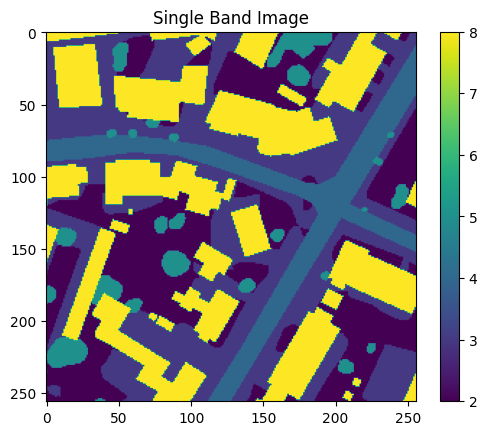

In [476]:
single_band = image_array_y[0]  # Supposons que `nb_bands` = 1

# Afficher avec imshow
plt.imshow(single_band)  # Utiliser cmap='gray' pour les niveaux de gris
plt.colorbar()  # Afficher une barre de couleurs pour visualiser les valeurs
plt.title("Single Band Image")
plt.show()

In [477]:
image_array_y.shape

(1, 256, 256)

In [478]:
np.expand_dims(image_array, axis = 0).shape

(1, 256, 256, 3)

In [479]:
y_pred = model.predict(np.expand_dims(image_array, axis = 0))

1/1 [==============================] - 0s 14ms/step


In [480]:
y_pred.shape

(1, 256, 256, 9)

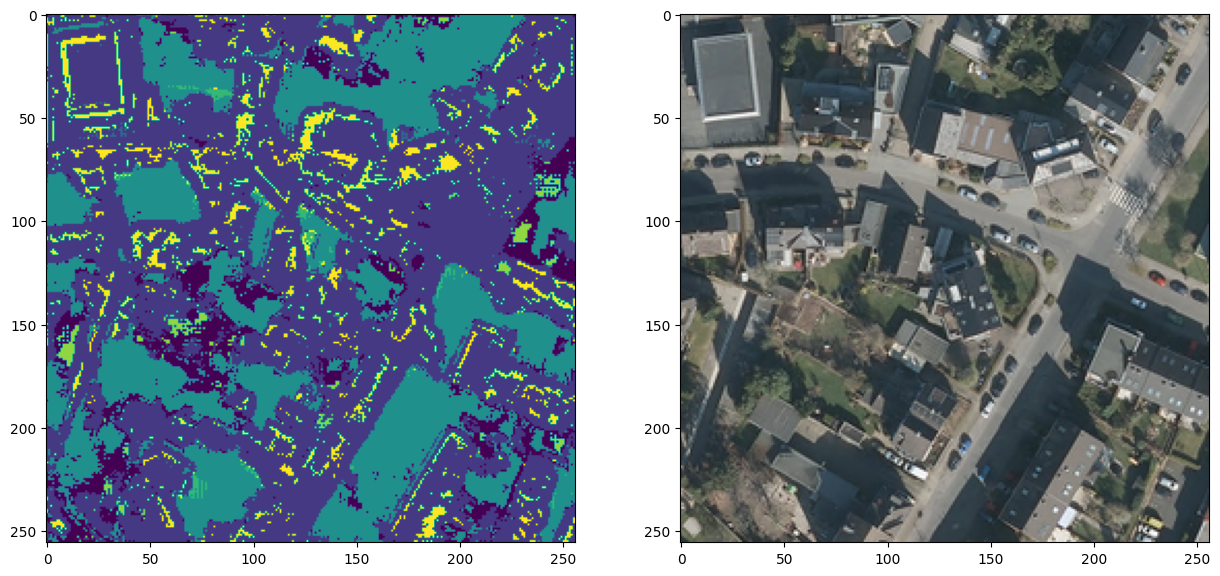

In [481]:
fig, ax = plt.subplots(1,2, figsize = (15,15))
ax[0].imshow(np.squeeze(tf.argmax(y_pred, axis=-1, output_type=tf.int32).numpy()))
ax[1].imshow(image_array)

In [457]:
image_array_y.shape

(256, 3, 256)

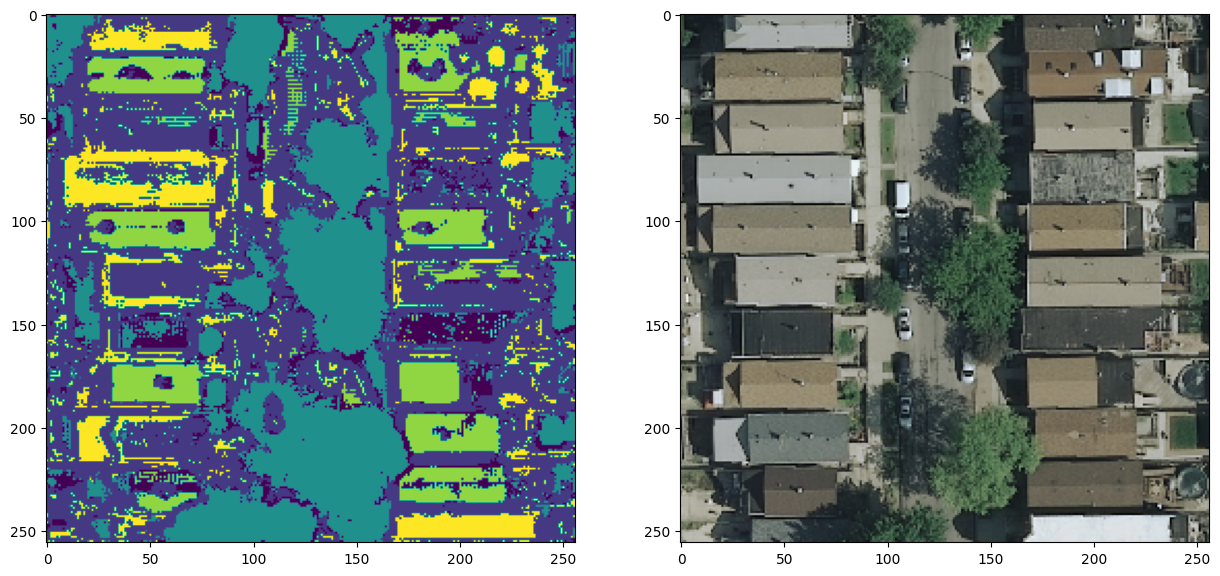

In [472]:
fig, ax = plt.subplots(1,2, figsize = (15,15))
ax[0].imshow(np.squeeze(tf.argmax(y_pred, axis=-1, output_type=tf.int32).numpy()))
ax[1].imshow(image_array)

## Next step model comme VG16 (regarder Notion)